# Práctica 5: Tech evolution. Caso POS Tagging

**Fecha de entrega: 13 de Abril 2025**

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

In [5]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from rich import print as rprint
import requests
import random 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Working on device={device}")

Working on device=cuda


In [7]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [8]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [9]:
def extract_features(sentence: list[str], context: int=2) -> list:
    """Extraer las features de cada oración

    Para tener siempre la misma cantidad de features
    por oración aplica un ventaneo llenando los espacios
    restantes con "<BOS>" y "<EOS>"

    Parameters
    ----------
    sentence: list[str]
        Oracion en formato CoNLL
    context: int
        Cantidad de palabras a la izquierda y derecha de la palabra actual. Default: 2

    Return
    ------
    list
        Lista de diccionarios con las features de cada palabra
    """
    start_pad = ["<BOS>"] * context
    end_pad = ["<EOS>"] * context
    sentence = start_pad + sentence + end_pad
    features = []
    for i in range(len(sentence) - 2 * context):
        aux = []
        for j in range(2 * context + 1):
            aux += [sentence[i + j]]
        features += [aux]
    features = [dict(enumerate(feature)) for feature in features]
    return features

def extract_corpus_features(words_set: list[list[str]], pos_tags_set: list[list[str]]):
    """Extraer las features del corpus

    Parameters
    ----------
    words_set: list[list[str]]
        Lista de listas con las palabras de cada oración
    pos_tags_set: list[list[str]]
        Lista de listas con las etiquetas POS de cada oración

    Return
    ------
    tuple
        Tupla con las features y las etiquetas POS
    """
    X_features = [row for sent in words_set for row in extract_features(sent)]
    y_features = [pos for sent in pos_tags_set for pos in sent]
    return X_features, y_features

In [11]:
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors


def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

vectors = gensim_api.load("glove-wiki-gigaword-100")
embeddings = get_embeddings(vectors)

In [12]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [13]:
EMBEDDING_DIM = 100

conll_dict = CoNLLDictorizer()
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
train_sent_words, train_sent_pos = zip(*train_pairs)
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))


embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [14]:
embeddings_words_rnn

dict_keys(['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.', 'so', 'them', 'what', 'him', 'united', 'during', 'before', 'may', 'since', 'many', 'while', 'where', 'states', 'because', 'now', 'city', 'made', 'like', 'between', 'did', 'just', 'national', 'day', 'country', 'under', 'such', 'second', 'then', 'company', 'group

In [15]:
corpus_words_rnn

['!',
 '"',
 '#',
 '#1',
 '#13',
 '#44',
 '#advice',
 '#analysis',
 '#argument',
 '#causalargument',
 '#cognitivebias',
 '#currentevents',
 '#ethos',
 '#finances',
 '#health',
 '#istandwithahmed',
 '#kairos',
 '#langu',
 '#logos',
 '#pathos',
 '#proposal',
 '#reportinginformation',
 '#research',
 '#sharedvalues',
 '#systemanalysis',
 '#writinglife',
 '$',
 '$2,000',
 '%',
 '&',
 "'",
 "'60's",
 "'70's",
 "'71",
 "'cause",
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'scopes",
 "'ve",
 '(',
 '(a)',
 '(b)',
 '(c)',
 '(d)',
 ')',
 '*',
 '+',
 '+1602275-4958',
 '+1918584-4428',
 '+4533330040',
 '+4550981306',
 '+4588304520',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '.2',
 '.203',
 '.227',
 '.265',
 '.292',
 '.322',
 '.324',
 '.348',
 '.4',
 '.432',
 '.5',
 '/',
 '0',
 '0.05',
 '0.2',
 '0.3',
 '0.4',
 '0.6',
 '0.8',
 '03:00',
 '0590258046',
 '0590854950',
 '0590854959',
 '0590883899',
 '0590920648',
 '06:30',
 '08',
 '08:00',
 '08:30',
 '1',
 '1)',
 '1,000',
 '1,095,000',
 '1,426',
 '1,537,058',


In [16]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo

In [17]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
idx2pos = dict(enumerate(set(y_train_features)))
pos2idx = {v: k for k, v in idx2pos.items()}

In [18]:
hidden_size = 128           
num_classes = 20            
freeze_embeddings = False   
num_layers = 2
bidirectional = False

model = RnnModel(
    embedding_table=embedding_table,
    hidden_size=hidden_size,
    num_classes=num_classes,
    freeze_embeddings=freeze_embeddings,
    num_layers=num_layers,
    bidirectional=bidirectional
)

model.load_state_dict(torch.load("pos_tagger_rnn_cuda_9.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

/tmp/ipykernel_1823/3175769683.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pos_tagger_rnn_cuda_9.pth", map_location='cuda' if torc

RnnModel(
  (embedding): Embedding(401202, 100, padding_idx=0)
  (recurrent): RNN(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=20, bias=True)
)

In [19]:
embedding_weight = model.embedding.weight.data  

vocab_size, embedding_dim = embedding_weight.shape
print(f"Vocab size: {vocab_size}, Embedding dim: {embedding_dim}")
idx2word = dict(enumerate(vocabulary), start=2)
word2idx = {v: k for k, v in idx2word.items()}


valid_words = [word for window in X_train_features for word in [window[2]] if word.isalpha()]
random_indices = random.sample(range(len(valid_words)), 100)

print("\n\n######### Embeddings de 100 palabras del vocabulario #########\n")
idx2word = {idx: word for word, idx in word2idx.items()}
embedding_seleccionados = []
for idx in random_indices:
    print(f"{idx2word[idx]}: {embedding_weight[idx][:5]}...")
    embedding_seleccionados.append(embedding_weight[idx])

Vocab size: 401202, Embedding dim: 100


######### Embeddings de 100 palabras del vocabulario #########

ruthann: tensor([ 0.4315, -0.0282, -0.7522,  0.4415,  0.0604], device='cuda:0')...
everywoman: tensor([-0.5274,  0.6852,  0.0322, -0.0385,  0.8934], device='cuda:0')...
masanari: tensor([-0.2590, -0.6341, -0.0759,  0.8758, -0.6011], device='cuda:0')...
ponson: tensor([ 0.1939, -0.2084, -0.1093, -0.2846, -0.1770], device='cuda:0')...
catatonia: tensor([-0.0216,  0.9455,  0.7463,  0.4828, -0.4818], device='cuda:0')...
slurries: tensor([ 0.0494, -0.7123,  0.0483,  0.2400, -0.1948], device='cuda:0')...
at40: tensor([ 0.0829, -0.6887, -0.4072,  0.4180, -0.2438], device='cuda:0')...
1949: tensor([ 0.1723, -0.2133, -0.2996,  0.2879, -0.2521], device='cuda:0')...
declining: tensor([-0.0238,  0.4319, -0.1560,  0.3331, -0.0577], device='cuda:0')...
wnnx: tensor([ 0.1560, -0.2398,  0.0098, -0.1155,  0.0113], device='cuda:0')...
venlo: tensor([ 0.0739, -0.0595, -0.0124,  0.4004,  0.9537], devic

- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters


Input data:
- Type: <class 'numpy.ndarray'>
- Shape: (100, 100)
Evaluando K-Means...
Evaluando Agglomerative Clustering...
Evaluando Gaussian Mixture...
Evaluando Spectral Clustering...


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API h

Evaluando BIRCH...
Evaluando DBSCAN...

MÉTODO: KMEANS
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: AGGLOMERATIVE
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.207
- Calinski-Harabasz Score: 5.335
- Davies-Bouldin Score: 2.765

MÉTODO: GMM
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: SPECTRAL
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.034
- Calinski-Harabasz Score: 3.472
- Davies-Bouldin Score: 4.809

MÉTODO: BIRCH
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.230
- Calinski-Harabasz Score: 5.468
- Davies-Bouldin Score: 2.491

MÉTODO: DBSCAN
Número de clusters encontrados: 1

No se encontraron clusters válidos para calcular métricas.


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


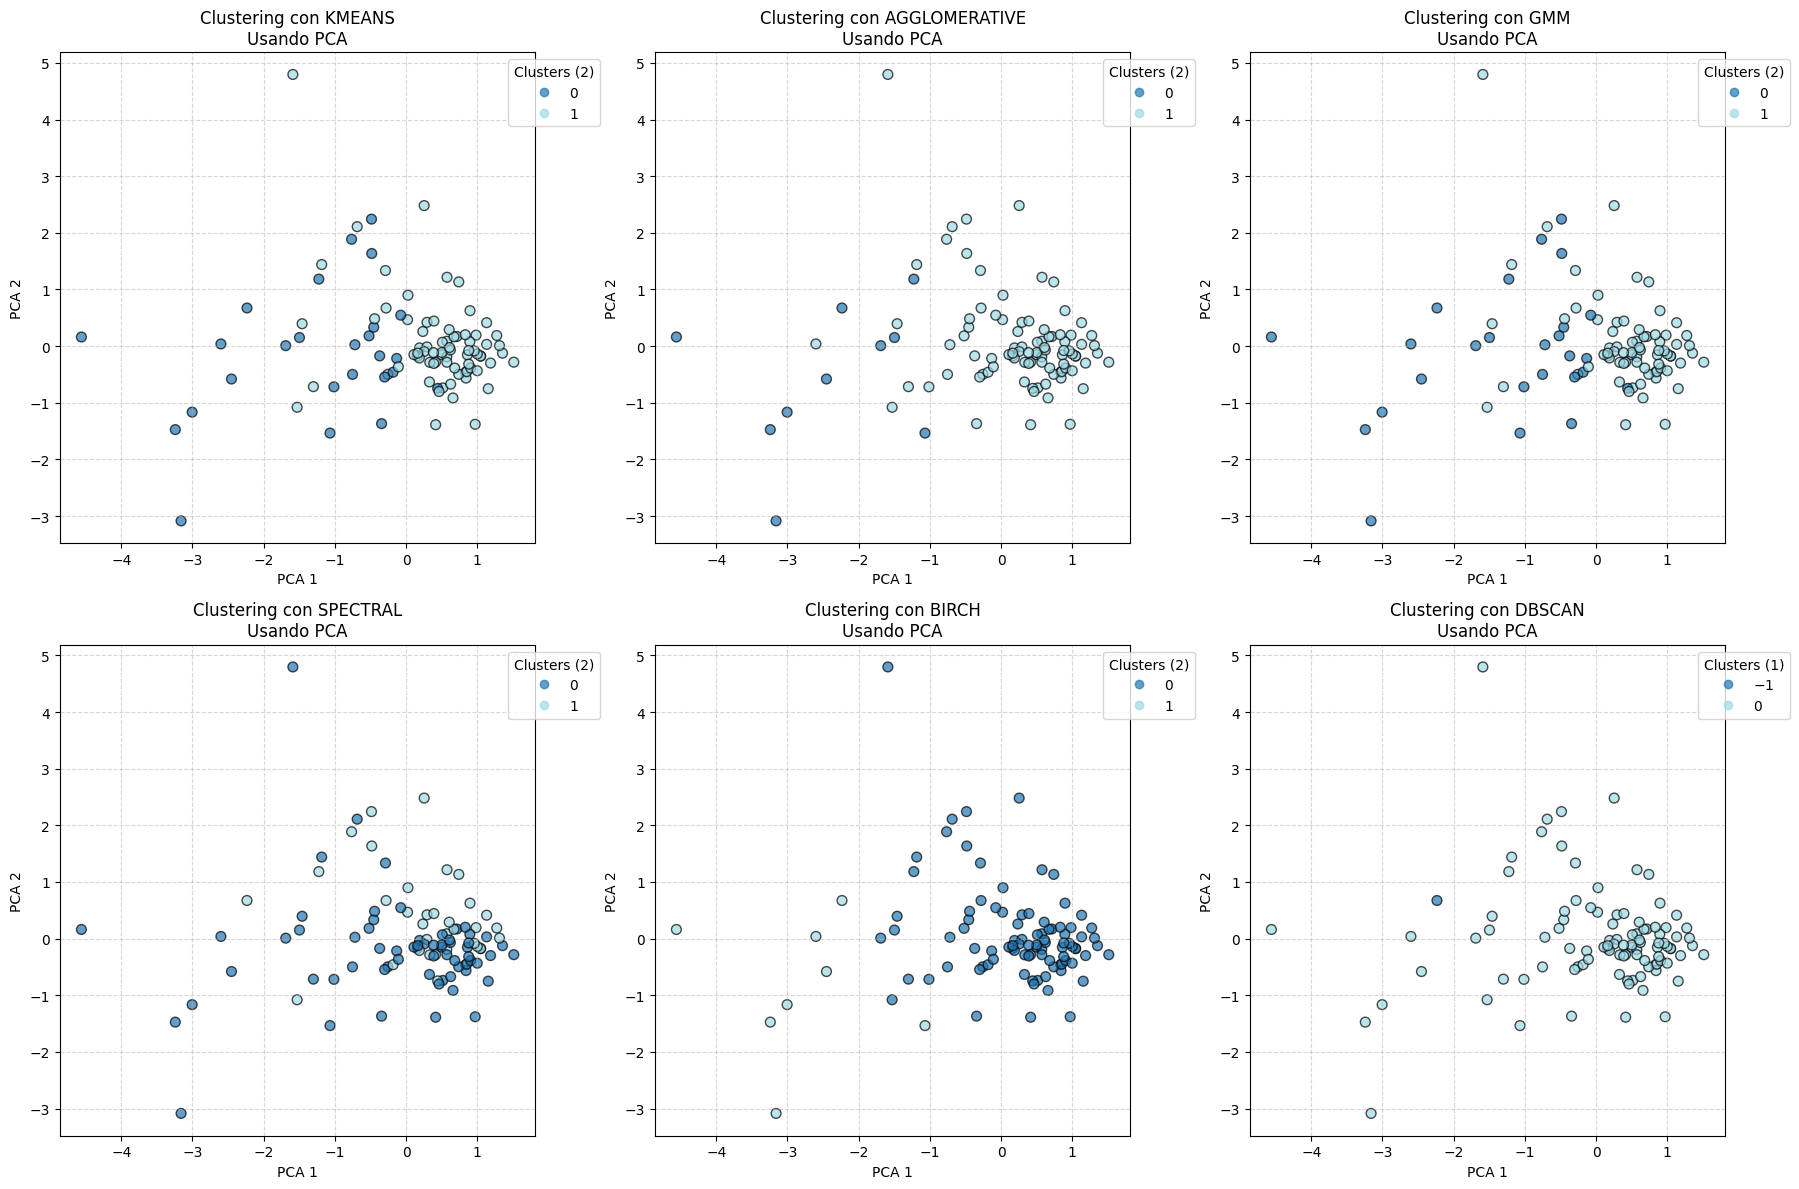

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import (AgglomerativeClustering, KMeans, 
                           DBSCAN, SpectralClustering, Birch)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

def evaluate_clustering(embeddings, k_range=(2, 11), random_state=42):
    """Función corregida para manejar diferentes tipos de entrada"""
    
    if not isinstance(embeddings, np.ndarray):
        try:
            embeddings = np.array(embeddings, dtype=float)
        except (TypeError, ValueError) as e:
            raise ValueError("Los embeddings deben ser convertibles a array NumPy de números") from e
    
    
    if not np.issubdtype(embeddings.dtype, np.number):
        raise ValueError("Los embeddings deben contener solo valores numéricos")
    
    results = {}
    k_values = list(range(k_range[0], k_range[1]))
    
    
    
    embeddings_norm = normalize(embeddings)
    
    
    results = {}
    k_values = list(range(k_range[0], k_range[1]))
    


    
    # 1. K-Means
    print("Evaluando K-Means...")
    kmeans_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        kmeans_scores.append(score)
    best_k_kmeans = k_values[np.argmax(kmeans_scores)]
    results['kmeans'] = {
        'best_k': best_k_kmeans,
        'scores': kmeans_scores,
        'model': KMeans(n_clusters=best_k_kmeans, random_state=random_state)
    }
    
    # 2. Agglomerative Clustering
    print("Evaluando Agglomerative Clustering...")
    agg_scores = []
    for k in k_values:
        agg = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='average')
        labels = agg.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels, metric='cosine')
        agg_scores.append(score)
    best_k_agg = k_values[np.argmax(agg_scores)]
    results['agglomerative'] = {
        'best_k': best_k_agg,
        'scores': agg_scores,
        'model': AgglomerativeClustering(n_clusters=best_k_agg, metric='cosine', linkage='average')
    }
    
    # 3. Gaussian Mixture
    print("Evaluando Gaussian Mixture...")
    gmm_scores = []
    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        labels = gmm.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        gmm_scores.append(score)
    best_k_gmm = k_values[np.argmax(gmm_scores)]
    results['gmm'] = {
        'best_k': best_k_gmm,
        'scores': gmm_scores,
        'model': GaussianMixture(n_components=best_k_gmm, random_state=random_state)
    }
    
    # 4. Spectral Clustering
    print("Evaluando Spectral Clustering...")
    spectral_scores = []
    for k in k_values:
        spectral = SpectralClustering(n_clusters=k, random_state=random_state, 
                                    affinity='nearest_neighbors', n_neighbors=10)
        labels = spectral.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        spectral_scores.append(score)
    best_k_spectral = k_values[np.argmax(spectral_scores)]
    results['spectral'] = {
        'best_k': best_k_spectral,
        'scores': spectral_scores,
        'model': SpectralClustering(n_clusters=best_k_spectral, random_state=random_state,
                                  affinity='nearest_neighbors', n_neighbors=10)
    }
    
    # 5. BIRCH
    print("Evaluando BIRCH...")
    birch_scores = []
    for k in k_values:
        birch = Birch(n_clusters=k)
        labels = birch.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        birch_scores.append(score)
    best_k_birch = k_values[np.argmax(birch_scores)]
    results['birch'] = {
        'best_k': best_k_birch,
        'scores': birch_scores,
        'model': Birch(n_clusters=best_k_birch)
    }
    
    # 6. DBSCAN 
    print("Evaluando DBSCAN...")
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(embeddings_norm)
    distances, _ = nbrs.kneighbors(embeddings_norm)
    distances = np.sort(distances[:, -1], axis=0)
    
    # Encontrar el "codo" en la curva de distancias
    eps = None
    for i in range(1, len(distances)):
        if distances[i] - distances[i-1] > 0.1 * distances[-1]:
            eps = distances[i]
            break
    if eps is None:
        eps = distances[int(0.95 * len(distances))]  
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(embeddings_norm)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    
    if n_clusters > 1:  
        dbscan_score = silhouette_score(embeddings_norm, dbscan_labels)
    else:
        dbscan_score = -1
    
    results['dbscan'] = {
        'best_k': n_clusters,
        'score': dbscan_score,
        'model': dbscan,
        'eps': eps,
        'labels': dbscan_labels
    }
    
    return results
    
# 2. Función para reducir dimensionalidad
def reduce_dimensions(embeddings, method='pca', random_state=42):
    """
    Reduce la dimensionalidad de los embeddings a 2D.
    
    Parámetros:
    - embeddings: np.ndarray - Embeddings en alta dimensión
    - method: str - Método de reducción ('pca' o 'tsne') (default: 'pca')
    - random_state: int - Semilla para reproducibilidad (default: 42)
    
    Retorna:
    - np.ndarray: Embeddings en 2D
    """
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=random_state)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, 
                      random_state=random_state, init='pca')
    else:
        raise ValueError("Método de reducción no válido. Usa 'pca' o 'tsne'.")
    
    return reducer.fit_transform(embeddings)

# 3. Función para visualizar clusters
def plot_clusters(embeddings_2d, labels, method_name, reduction_method, ax=None):
    """
    Visualiza los clusters en 2D.
    
    Parámetros:
    - embeddings_2d: np.ndarray - Embeddings reducidos a 2D
    - labels: np.ndarray - Etiquetas de cluster para cada punto
    - method_name: str - Nombre del método de clustering
    - reduction_method: str - Método de reducción usado
    - ax: matplotlib.axes.Axes - Ejes para plotear (opcional)
    """
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                        c=labels, cmap='tab20', s=50, edgecolor='k', alpha=0.7)
    
    ax.legend(*scatter.legend_elements(),
             title=f"Clusters ({n_clusters})",
             loc="upper right",
             bbox_to_anchor=(1.15, 1))
    ax.set_title(f"Clustering con {method_name.upper()}\nUsando {reduction_method.upper()}")
    ax.set_xlabel(f"{reduction_method.upper()} 1")
    ax.set_ylabel(f"{reduction_method.upper()} 2")
    ax.grid(True, linestyle='--', alpha=0.5)

# 4. Función para imprimir métricas
def print_metrics(embeddings, labels, method_name):
    """
    Imprime métricas de evaluación para el clustering.
    
    Parámetros:
    - embeddings: np.ndarray - Embeddings originales
    - labels: np.ndarray - Etiquetas de cluster
    - method_name: str - Nombre del método de clustering
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    print(f"\n{'='*50}")
    print(f"MÉTODO: {method_name.upper()}")
    print(f"Número de clusters encontrados: {n_clusters}")
    
    if n_clusters > 1:
        print(f"\nMétricas:")
        print(f"- Silhouette Score: {silhouette_score(embeddings, labels):.3f}")
        print(f"- Calinski-Harabasz Score: {calinski_harabasz_score(embeddings, labels):.3f}")
        print(f"- Davies-Bouldin Score: {davies_bouldin_score(embeddings, labels):.3f}")
    else:
        print("\nNo se encontraron clusters válidos para calcular métricas.")

def clustering_plot(embeddings, reduction_method='pca', random_state=42):
    """Visualización de clustering con reducción de dimensionalidad"""
    
    
    if isinstance(embeddings, list):
        embeddings = [tensor.cpu().detach().numpy() if hasattr(tensor, 'is_cuda') else 
                     tensor.detach().numpy() if hasattr(tensor, 'detach') else 
                     np.array(tensor) 
                     for tensor in embeddings]
        embeddings = np.stack(embeddings)  
    elif hasattr(embeddings, 'is_cuda'):

        embeddings = embeddings.cpu().detach().numpy()
    elif hasattr(embeddings, 'detach'):

        embeddings = embeddings.detach().numpy()
    else:

        embeddings = np.array(embeddings)
    
    print(f"\nInput data:")
    print(f"- Type: {type(embeddings)}")
    print(f"- Shape: {embeddings.shape}")

    clustering_results = evaluate_clustering(embeddings, random_state=random_state)
    embeddings_2d = reduce_dimensions(embeddings, method=reduction_method, random_state=random_state)
        
        # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
        
    for i, (method_name, result) in enumerate(clustering_results.items()):
        if method_name == 'dbscan':
            labels = result['labels']
        else:
            model = result['model']
            labels = model.fit_predict(embeddings)
            
        plot_clusters(embeddings_2d, labels, method_name, reduction_method, ax=axes[i])
        print_metrics(embeddings, labels, method_name)
        
    plt.tight_layout()
    plt.show()

        


    
clustering_plot(embedding_seleccionados, reduction_method='pca')





Input data:
- Type: <class 'numpy.ndarray'>
- Shape: (100, 100)
Evaluando K-Means...
Evaluando Agglomerative Clustering...
Evaluando Gaussian Mixture...
Evaluando Spectral Clustering...


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API h

Evaluando BIRCH...
Evaluando DBSCAN...


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



MÉTODO: KMEANS
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: AGGLOMERATIVE
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.207
- Calinski-Harabasz Score: 5.335
- Davies-Bouldin Score: 2.765

MÉTODO: GMM
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: SPECTRAL
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.034
- Calinski-Harabasz Score: 3.472
- Davies-Bouldin Score: 4.809

MÉTODO: BIRCH
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.230
- Calinski-Harabasz Score: 5.468
- Davies-Bouldin Score: 2.491

MÉTODO: DBSCAN
Número de clusters encontrados: 1

No se encontraron clusters válidos para calcular métricas.


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


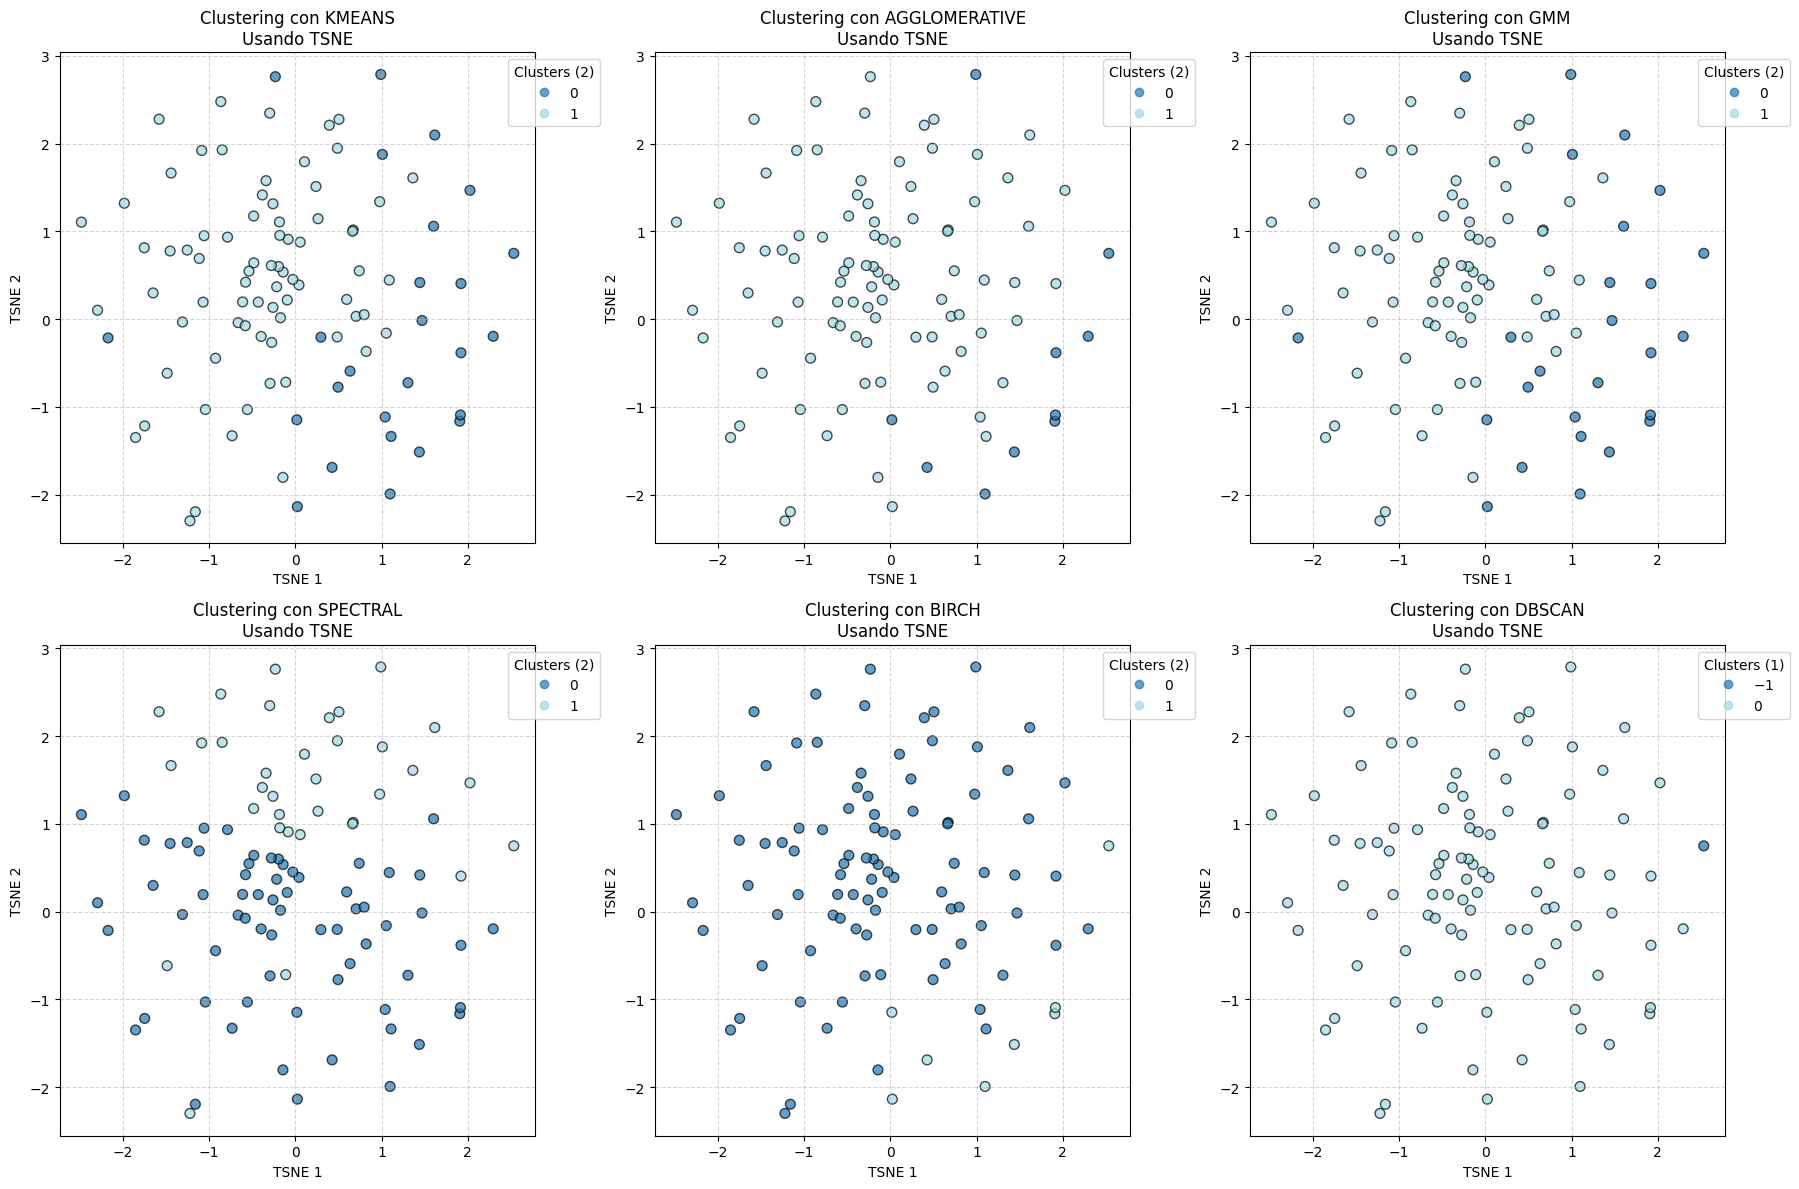

In [21]:
clustering_plot(embedding_seleccionados, reduction_method='tsne')

- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras

In [22]:
pos_embeddings = model.linear.weight.detach().cpu().numpy()
print("\n\n######### Etiqueta pos de 100 palabras del vocabulario #########\n")
tensor = torch.LongTensor(random_indices).unsqueeze(0).to(device)
outputs = model(tensor)
predictions = torch.argmax(outputs, dim=-1).squeeze().cpu().numpy()

for pred, word in zip(predictions, random_indices):
    print(f'Palabra {idx2word[word]} - etiqueta pos: {idx2pos[pred]}')



######### Etiqueta pos de 100 palabras del vocabulario #########

Palabra ruthann - etiqueta pos: PUNCT
Palabra everywoman - etiqueta pos: SCONJ
Palabra masanari - etiqueta pos: SCONJ
Palabra ponson - etiqueta pos: PUNCT
Palabra catatonia - etiqueta pos: VERB
Palabra slurries - etiqueta pos: DET
Palabra at40 - etiqueta pos: SCONJ
Palabra 1949 - etiqueta pos: DET
Palabra declining - etiqueta pos: DET
Palabra wnnx - etiqueta pos: SCONJ
Palabra venlo - etiqueta pos: PUNCT
Palabra újpesti - etiqueta pos: DET
Palabra suits - etiqueta pos: NUM
Palabra bavier - etiqueta pos: DET
Palabra nikau - etiqueta pos: NUM
Palabra bhawal - etiqueta pos: DET
Palabra karten - etiqueta pos: PUNCT
Palabra suderman - etiqueta pos: SCONJ
Palabra mbeya - etiqueta pos: NUM
Palabra arryn - etiqueta pos: SCONJ
Palabra dolomitic - etiqueta pos: NUM
Palabra padgham - etiqueta pos: DET
Palabra mcguiness - etiqueta pos: NUM
Palabra bordars - etiqueta pos: DET
Palabra rouben - etiqueta pos: PUNCT
Palabra midibus - e


Input data:
- Word embeddings shape: (100, 100)
- POS embeddings shape: (20, 128)
- POS labels: ['AUX', 'PART', 'NOUN', 'CCONJ', 'VERB', '_', 'PROPN', 'PUNCT', 'ADV', 'INTJ', 'ADJ', 'NUM', 'SYM', 'X', 'PRON', 'SCONJ', 'ADP', 'DET']
Evaluando K-Means...
Evaluando Agglomerative Clustering...
Evaluando Gaussian Mixture...
Evaluando Spectral Clustering...


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API h

Evaluando BIRCH...
Evaluando DBSCAN...

MÉTODO: KMEANS
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: AGGLOMERATIVE
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.207
- Calinski-Harabasz Score: 5.335
- Davies-Bouldin Score: 2.765

MÉTODO: GMM
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.133
- Calinski-Harabasz Score: 5.058
- Davies-Bouldin Score: 3.982

MÉTODO: SPECTRAL
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.034
- Calinski-Harabasz Score: 3.472
- Davies-Bouldin Score: 4.809


/home/carloscmora/miniconda3/envs/tf3/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(



MÉTODO: BIRCH
Número de clusters encontrados: 2

Métricas:
- Silhouette Score: 0.230
- Calinski-Harabasz Score: 5.468
- Davies-Bouldin Score: 2.491

MÉTODO: DBSCAN
Número de clusters encontrados: 1

No se encontraron clusters válidos para calcular métricas.


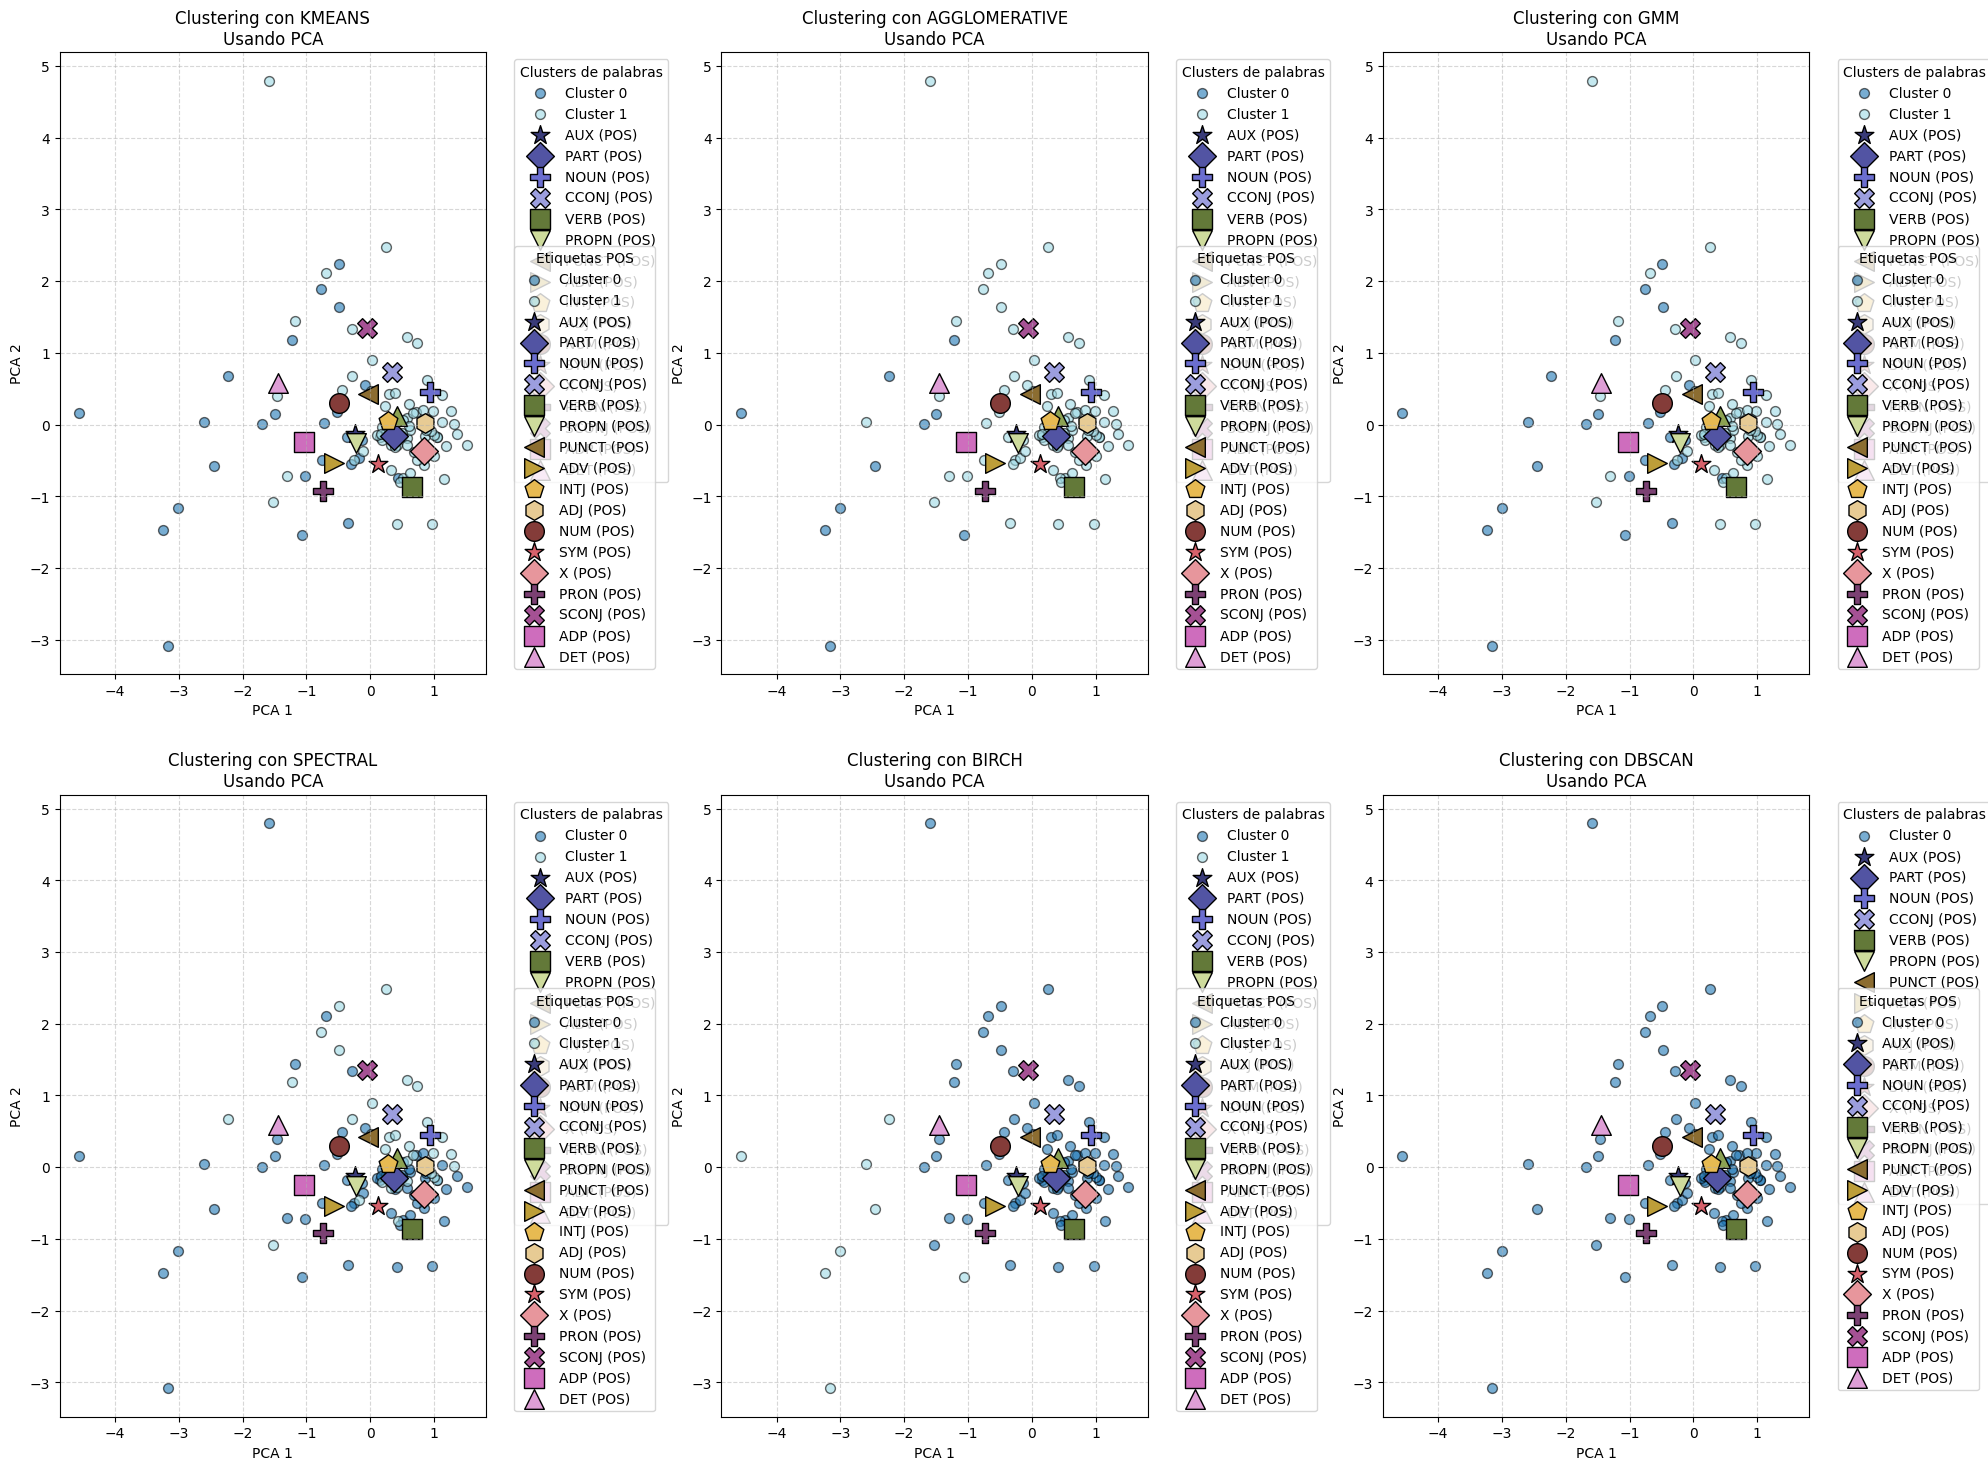

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import (AgglomerativeClustering, KMeans, 
                           DBSCAN, SpectralClustering, Birch)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

def evaluate_clustering(embeddings, k_range=(2, 11), random_state=42):
    """Función corregida para manejar diferentes tipos de entrada"""
    
    if not isinstance(embeddings, np.ndarray):
        try:
            embeddings = np.array(embeddings, dtype=float)
        except (TypeError, ValueError) as e:
            raise ValueError("Los embeddings deben ser convertibles a array NumPy de números") from e
    
    if not np.issubdtype(embeddings.dtype, np.number):
        raise ValueError("Los embeddings deben contener solo valores numéricos")
    
    results = {}
    k_values = list(range(k_range[0], k_range[1]))
    
    embeddings_norm = normalize(embeddings)
    
    # 1. K-Means
    print("Evaluando K-Means...")
    kmeans_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        kmeans_scores.append(score)
    best_k_kmeans = k_values[np.argmax(kmeans_scores)]
    results['kmeans'] = {
        'best_k': best_k_kmeans,
        'scores': kmeans_scores,
        'model': KMeans(n_clusters=best_k_kmeans, random_state=random_state)
    }
    
    # 2. Agglomerative Clustering
    print("Evaluando Agglomerative Clustering...")
    agg_scores = []
    for k in k_values:
        agg = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='average')
        labels = agg.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels, metric='cosine')
        agg_scores.append(score)
    best_k_agg = k_values[np.argmax(agg_scores)]
    results['agglomerative'] = {
        'best_k': best_k_agg,
        'scores': agg_scores,
        'model': AgglomerativeClustering(n_clusters=best_k_agg, metric='cosine', linkage='average')
    }
    
    # 3. Gaussian Mixture
    print("Evaluando Gaussian Mixture...")
    gmm_scores = []
    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        labels = gmm.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        gmm_scores.append(score)
    best_k_gmm = k_values[np.argmax(gmm_scores)]
    results['gmm'] = {
        'best_k': best_k_gmm,
        'scores': gmm_scores,
        'model': GaussianMixture(n_components=best_k_gmm, random_state=random_state)
    }
    
    # 4. Spectral Clustering
    print("Evaluando Spectral Clustering...")
    spectral_scores = []
    for k in k_values:
        spectral = SpectralClustering(n_clusters=k, random_state=random_state, 
                                    affinity='nearest_neighbors', n_neighbors=10)
        labels = spectral.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        spectral_scores.append(score)
    best_k_spectral = k_values[np.argmax(spectral_scores)]
    results['spectral'] = {
        'best_k': best_k_spectral,
        'scores': spectral_scores,
        'model': SpectralClustering(n_clusters=best_k_spectral, random_state=random_state,
                                  affinity='nearest_neighbors', n_neighbors=10)
    }
    
    # 5. BIRCH
    print("Evaluando BIRCH...")
    birch_scores = []
    for k in k_values:
        birch = Birch(n_clusters=k)
        labels = birch.fit_predict(embeddings_norm)
        score = silhouette_score(embeddings_norm, labels)
        birch_scores.append(score)
    best_k_birch = k_values[np.argmax(birch_scores)]
    results['birch'] = {
        'best_k': best_k_birch,
        'scores': birch_scores,
        'model': Birch(n_clusters=best_k_birch)
    }
    
    # 6. DBSCAN 
    print("Evaluando DBSCAN...")
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(embeddings_norm)
    distances, _ = nbrs.kneighbors(embeddings_norm)
    distances = np.sort(distances[:, -1], axis=0)
    
    eps = None
    for i in range(1, len(distances)):
        if distances[i] - distances[i-1] > 0.1 * distances[-1]:
            eps = distances[i]
            break
    if eps is None:
        eps = distances[int(0.95 * len(distances))]  
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(embeddings_norm)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    
    if n_clusters > 1:  
        dbscan_score = silhouette_score(embeddings_norm, dbscan_labels)
    else:
        dbscan_score = -1
    
    results['dbscan'] = {
        'best_k': n_clusters,
        'score': dbscan_score,
        'model': dbscan,
        'eps': eps,
        'labels': dbscan_labels
    }
    
    return results
    
def reduce_dimensions(embeddings, method='pca', random_state=42):
    """
    Reduce la dimensionalidad de los embeddings a 2D.
    """
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=random_state)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, 
                      random_state=random_state, init='pca')
    else:
        raise ValueError("Método de reducción no válido. Usa 'pca' o 'tsne'.")
    
    return reducer.fit_transform(embeddings)

def plot_clusters_with_pos(word_embeddings_2d, pos_embeddings_2d, word_labels, pos_labels, 
                          method_name, reduction_method, ax=None):
    """
    Visualiza clusters de palabras junto con embeddings POS.
    
    Parámetros:
    - word_embeddings_2d: np.ndarray - Embeddings de palabras reducidos a 2D
    - pos_embeddings_2d: np.ndarray - Embeddings POS reducidos a 2D
    - word_labels: np.ndarray - Etiquetas de cluster para palabras
    - pos_labels: list - Lista de nombres de etiquetas POS
    - method_name: str - Nombre del método de clustering
    - reduction_method: str - Método de reducción usado
    - ax: matplotlib.axes.Axes - Ejes para plotear (opcional)
    """
    if ax is None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
    
    n_word_clusters = len(set(word_labels)) - (1 if -1 in word_labels else 0)
    n_pos = len(pos_embeddings_2d)
    
    # Colores y marcadores
    word_colors = plt.cm.tab20(np.linspace(0, 1, n_word_clusters))
    pos_markers = ['*', 'D', 'P', 'X', 's', '^', 'v', '<', '>', 'p', 'h', 'o']
    pos_colors = plt.cm.tab20b(np.linspace(0, 1, n_pos))
    
    # Plotear palabras
    for cluster in range(n_word_clusters):
        mask = word_labels == cluster
        ax.scatter(word_embeddings_2d[mask, 0], word_embeddings_2d[mask, 1],
                  color=word_colors[cluster],
                  s=50, alpha=0.6, edgecolor='k',
                  label=f'Cluster {cluster}')
    
    # Plotear POS con marcadores distintos
    for pos_idx in range(n_pos):
        ax.scatter(pos_embeddings_2d[pos_idx, 0], pos_embeddings_2d[pos_idx, 1],
                  marker=pos_markers[pos_idx % len(pos_markers)],
                  s=200, color=pos_colors[pos_idx],
                  edgecolor='black', linewidth=1,
                  label=f'{pos_labels[pos_idx]} (POS)')
    
    # Leyendas
    word_legend = ax.legend(title="Clusters de palabras",
                          bbox_to_anchor=(1.05, 1), 
                          loc='upper left')
    ax.add_artist(word_legend)
    
    ax.legend(title="Etiquetas POS",
             bbox_to_anchor=(1.05, 0.7),
             loc='upper left')
    
    ax.set_title(f"Clustering con {method_name.upper()}\nUsando {reduction_method.upper()}")
    ax.set_xlabel(f"{reduction_method.upper()} 1")
    ax.set_ylabel(f"{reduction_method.upper()} 2")
    ax.grid(True, linestyle='--', alpha=0.5)

def clustering_plot_with_pos(word_embeddings, pos_embeddings, pos_label_names, 
                           reduction_method='pca', random_state=42):
    """
    Visualización de clustering con embeddings POS.
    
    Parámetros:
    - word_embeddings: Tensor/array - Embeddings de palabras
    - pos_embeddings: Tensor/array - Embeddings POS
    - pos_label_names: list - Nombres de las etiquetas POS
    - reduction_method: str - 'pca' o 'tsne'
    - random_state: int - Semilla aleatoria
    """
    
    if isinstance(word_embeddings, list):
        word_embeddings = [tensor.cpu().detach().numpy() if hasattr(tensor, 'is_cuda') else 
                          tensor.detach().numpy() if hasattr(tensor, 'detach') else 
                          np.array(tensor) 
                          for tensor in word_embeddings]
        word_embeddings = np.stack(word_embeddings)  
    elif hasattr(word_embeddings, 'is_cuda'):
        word_embeddings = word_embeddings.cpu().detach().numpy()
    elif hasattr(word_embeddings, 'detach'):
        word_embeddings = word_embeddings.detach().numpy()
    else:
        word_embeddings = np.array(word_embeddings)
    
    if hasattr(pos_embeddings, 'is_cuda'):
        pos_embeddings = pos_embeddings.cpu().detach().numpy()
    elif hasattr(pos_embeddings, 'detach'):
        pos_embeddings = pos_embeddings.detach().numpy()
    else:
        pos_embeddings = np.array(pos_embeddings)
    
    print(f"\nInput data:")
    print(f"- Word embeddings shape: {word_embeddings.shape}")
    print(f"- POS embeddings shape: {pos_embeddings.shape}")
    print(f"- POS labels: {pos_label_names}")

    
    clustering_results = evaluate_clustering(word_embeddings, random_state=random_state)
    
    
    word_embeddings_2d = reduce_dimensions(word_embeddings, method=reduction_method, 
                                         random_state=random_state)
    # Emparejar la cantidad de etiquetas con los embeddings
    min_len = min(len(pos_embeddings), len(pos_labels))
    pos_embeddings = pos_embeddings[:min_len]
    pos_label_names = pos_label_names[:min_len]

    pos_embeddings_2d = reduce_dimensions(pos_embeddings, method=reduction_method,
                                         random_state=random_state)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, (method_name, result) in enumerate(clustering_results.items()):
        if method_name == 'dbscan':
            word_labels = result['labels']
        else:
            model = result['model']
            word_labels = model.fit_predict(word_embeddings)
            
        plot_clusters_with_pos(word_embeddings_2d, pos_embeddings_2d, 
                              word_labels, pos_label_names,
                              method_name, reduction_method, ax=axes[i])
        
        # Imprimir métricas
        print(f"\n{'='*50}")
        print(f"MÉTODO: {method_name.upper()}")
        n_clusters = len(set(word_labels)) - (1 if -1 in word_labels else 0)
        print(f"Número de clusters encontrados: {n_clusters}")
        
        if n_clusters > 1:
            print(f"\nMétricas:")
            print(f"- Silhouette Score: {silhouette_score(word_embeddings, word_labels):.3f}")
            print(f"- Calinski-Harabasz Score: {calinski_harabasz_score(word_embeddings, word_labels):.3f}")
            print(f"- Davies-Bouldin Score: {davies_bouldin_score(word_embeddings, word_labels):.3f}")
        else:
            print("\nNo se encontraron clusters válidos para calcular métricas.")
    
    plt.tight_layout()
    plt.show()



pos_embeddings = model.linear.weight


tensor = torch.LongTensor(random_indices).unsqueeze(0).to(device)
outputs = model(tensor)
predictions = torch.argmax(outputs, dim=-1).squeeze().cpu().numpy()


pos_labels = list(idx2pos.values())


clustering_plot_with_pos(
    word_embeddings=embedding_seleccionados,
    pos_embeddings=pos_embeddings,
    pos_label_names=pos_labels,
    reduction_method='pca'
)

Al observar la visualización de los embeddings, se puede identificar cierta organización espacial entre las palabras; sin embargo, los elementos que pertenecen a un mismo clúster aún se muestran relativamente dispersos. Esto sugiere que, a pesar de compartir la misma etiqueta gramatical (POS), las palabras no se agrupan de manera completamente coherente en el espacio de representación.

Este comportamiento resulta llamativo, especialmente considerando que el modelo presenta una pérdida que disminuye correctamente durante el entrenamiento, así como una precisión aceptable en las métricas de validación. Una posible explicación para esta dispersión en las representaciones puede ser la alta dimensionalidad del espacio original, la cual podría dificultar la proyección efectiva en dimensiones reducidas para su visualización. No obstante, los resultados obtenidos en términos de rendimiento indican que el modelo sí logra capturar de manera adecuada las relaciones entre las palabras y sus respectivas etiquetas POS, a pesar de las aparentes inconsistencias en la distribución visual.


### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"Working on device={device}")

Working on device=cuda

In [27]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes
t = to_index(train_sent_words_rnn[:2], word2idx)
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)
from torch.nn.utils.rnn import pad_sequence
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)
EMBEDDING_DIM = 100
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)
EPOCHS = 10
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words
MODELS_PATH = "./models/rnn"

In [29]:
from tqdm import tqdm, trange

rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


In [32]:
import matplotlib.pyplot as plt

def plot_history(history: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history["accuracy"], label="Accuracy")
    axes[0].plot(history["val_accuracy"], label="Validation accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Loss")
    axes[1].plot(history["val_loss"], label="Validation loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

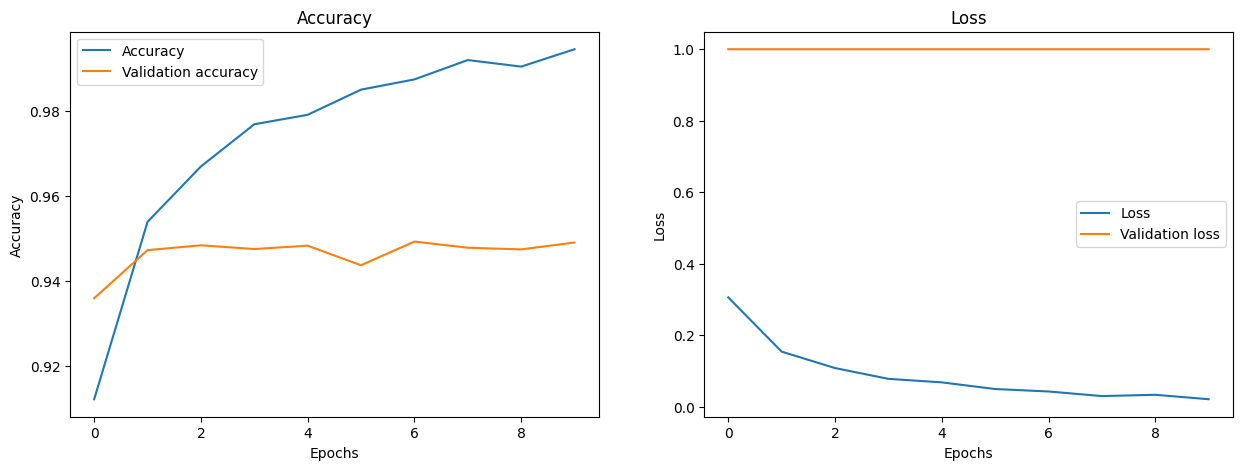

In [33]:
plot_history(rnn_history)

In [35]:
_, accuracy_rnn = evaluate_rnn(rnn_model, loss_fn, test_dataloader_rnn)
rprint(f"Accuracy (RNN): {accuracy_rnn * 100:.2f}%")

Accuracy (RNN): 93.92%

### LSTM

In [36]:
class LstmModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        out_dim = hidden_size * 2 if bidirectional else hidden_size
        self.linear = nn.Linear(out_dim, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds)
        logits = self.linear(lstm_out)
        return logits



In [39]:
MODELS_PATH = "./models/lstm"

In [41]:

lstm_model = LstmModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(lstm_model.parameters(), lr=0.005)

EPOCHS = 10
lstm_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}

for epoch in trange(EPOCHS):
    lstm_model.train()
    train_loss, train_acc, t_words = 0, 0, 0
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = lstm_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(-1)),
            y_batch.reshape(-1)
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            n_words = (y_batch > 0).sum().item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += (torch.argmax(y_batch_pred, dim=-1) == y_batch).masked_select(y_batch > 0).sum().item()

    val_loss, val_acc = evaluate_rnn(lstm_model, loss_fn, val_dataloader_rnn)
    
    lstm_history["accuracy"].append(train_acc / t_words)
    lstm_history["loss"].append(train_loss / t_words)
    lstm_history["val_loss"].append(val_loss)
    lstm_history["val_accuracy"].append(val_acc)

    torch.save(lstm_model.state_dict(), f"{MODELS_PATH}/pos_tagger_lstm_{device}_{epoch}.pth")

torch.save(lstm_history, f"{MODELS_PATH}/pos_tagger_lstm.history")


100%|██████████| 10/10 [03:30<00:00, 21.06s/it]


In [49]:
_, test_acc = evaluate_rnn(lstm_model, loss_fn, test_dataloader_rnn)

rprint(f"Accuracy (LSTM): {test_acc * 100:.2f}%")


Accuracy (LSTM): 94.62%

/tmp/ipykernel_1823/1840145801.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_history = torch.load(f"./models/rnn/pos_tagger_rnn.history")
/tmp/ipykernel_1823/18401

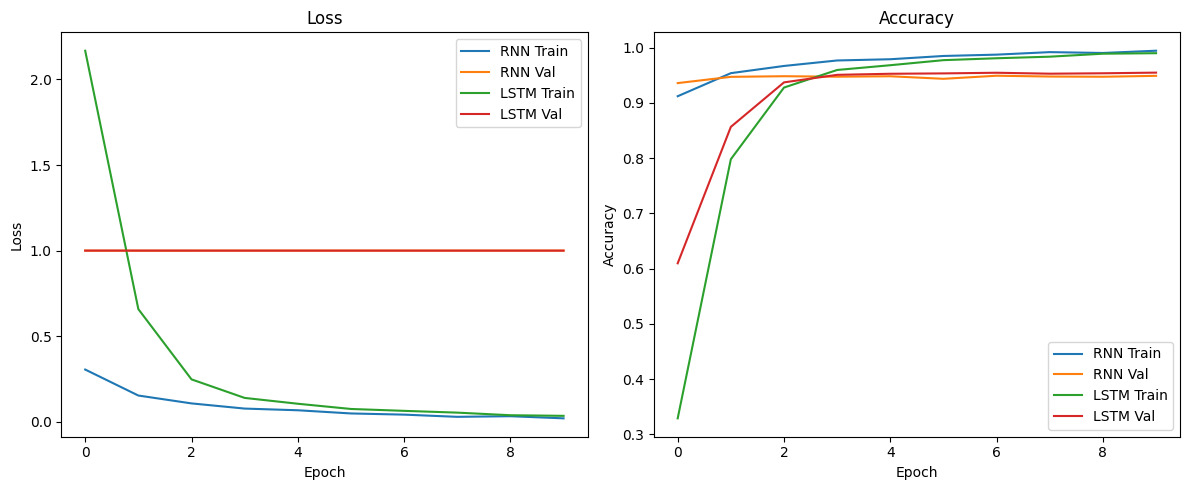

In [45]:
import matplotlib.pyplot as plt
import torch

rnn_history = torch.load(f"./models/rnn/pos_tagger_rnn.history")
lstm_history = torch.load(f"{MODELS_PATH}/pos_tagger_lstm.history")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rnn_history["loss"], label="RNN Train")
plt.plot(rnn_history["val_loss"], label="RNN Val")
plt.plot(lstm_history["loss"], label="LSTM Train")
plt.plot(lstm_history["val_loss"], label="LSTM Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history["accuracy"], label="RNN Train")
plt.plot(rnn_history["val_accuracy"], label="RNN Val")
plt.plot(lstm_history["accuracy"], label="LSTM Train")
plt.plot(lstm_history["val_accuracy"], label="LSTM Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Los resultados muestran que el modelo LSTM supera ligeramente al modelo RNN en la tarea de POS tagging:

Accuracy (RNN): 93.92%
Accuracy (LSTM): 94.62%

Esta diferencia, aunque pequeña, es significativa en tareas de procesamiento de lenguaje natural donde los errores pueden acumularse en tareas posteriores. La superioridad del modelo LSTM puede atribuirse a su capacidad para capturar dependencias de largo plazo y evitar el problema del desvanecimiento del gradiente, común en las RNN tradicionales. Además, la arquitectura bidireccional permite a ambos modelos acceder al contexto tanto anterior como posterior a cada palabra, lo cual es esencial para decisiones de etiquetado más precisas.